In [12]:
import numpy as np
import matplotlib.pyplot as plt


from hnc_n_multiscale import  HNC_solver
from qsps import *

# Two Species

Here we do QSP interactions between electrons and one ion type. 

Using $\tilde{r}\equiv r/r_s$, we implement potentials 
\begin{align}
\beta v_{ee}(\tilde{r}) &=  \frac{\Gamma_{ee}}{\tilde{r}}\left( 1- \exp[-\tilde{r} r_s/\Lambda_e]\right) +  \ln2 \exp\left[-\tilde{r}^2 r_s^2/(\pi \Lambda_e^2 \ln 2)\right]\\
\beta v_{ei}(\tilde{r}) &=  \frac{\Gamma_{ei}}{\tilde{r}}\left( 1- \exp[-\tilde{r} r_s/\Lambda_e]\right)\\
\beta v_{ii}(\tilde{r}) &=  \frac{\Gamma_{ii}}{\tilde{r}}
\end{align}
For  
\begin{align}
\Gamma_{ee}&=\frac{\beta e^2}{r_s}\\
\Gamma_{ei}&=\frac{\beta Z_i e^2}{r_s}\\
\Gamma_{ii}&=\frac{\beta Z_i^2 e^2}{r_s}\\
\end{align}

Plug into get potentials

In [2]:
ri=3
Te_c = 0.5*eV 
Ti   = 0.5*eV 
Z, A = 13, 27
Zstar= 3
# "Classical-Map  Hypernetted  Chain  Calculations  for  DensePlasmas"R. Bredow1∗, Th. Bornath1, W.-D. Kraeft1, M.W.C. Dharma-wardana2,andR. Redmer1
# Tq  = 1/5*qsp.E_F 


def make_Te(Te_c, Tq):
    Te  = np.sqrt(Tq**2 + Te_c**2)
    return Te
    
qsp = QSP_HNC(Z, A, Zstar, Te_c, Ti, ri)
Tq = 200*1/5*qsp.E_F 
qsp = QSP_HNC(Z, A, Zstar, make_Te(Te_c, Tq), Ti, ri)


Λee = 6.164
Γii=163.3, Γie=-54.4, Γee=18.1 
r_i=3.0
r_e=2.1
Λee = 0.202
Γii=163.3, Γie=-0.1, Γee=0.0 
r_i=3.0
r_e=2.1


/home/zach/plasma/hnc/qsps.py:93: RuntimeWarning: divide by zero encountered in true_divide
  return Γ/r* ( 1 -  np.exp(-np.sqrt(2)*π*r/self.Λe_star) )
/home/zach/plasma/hnc/qsps.py:93: RuntimeWarning: invalid value encountered in multiply
  return Γ/r* ( 1 -  np.exp(-np.sqrt(2)*π*r/self.Λe_star) )
/home/zach/plasma/hnc/qsps.py:97: RuntimeWarning: divide by zero encountered in true_divide
  return Γ/r*( 1 - np.exp(-2*π*r**2/self.Λe_star**2)+ np.sqrt(2)*π*r/self.Λe_star*erfc(np.sqrt(2*π)*r/self.Λe_star))
/home/zach/plasma/hnc/qsps.py:97: RuntimeWarning: invalid value encountered in multiply
  return Γ/r*( 1 - np.exp(-2*π*r**2/self.Λe_star**2)+ np.sqrt(2)*π*r/self.Λe_star*erfc(np.sqrt(2*π)*r/self.Λe_star))


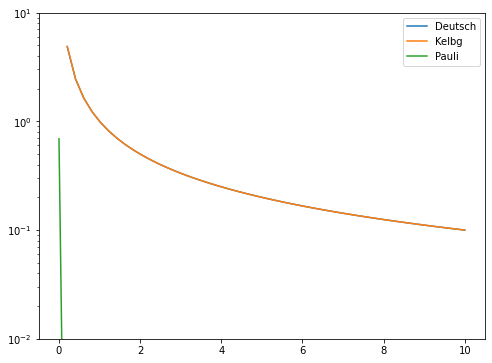

In [3]:

fig, ax = plt.subplots(figsize=(8,6),facecolor='w')

xs = np.linspace(0,10)
ax.plot(xs,qsp.βv_Deutsch(1,xs),label='Deutsch')
ax.plot(xs,qsp.βv_Kelbg(1,xs),label='Kelbg')
ax.plot(xs,qsp.βv_Pauli(xs),label='Pauli')

# ax.plot(xs, qsp.βvee(xs),label='βvee')
# ax.plot(xs, -qsp.βvei(xs),label='-βvei')
# ax.plot(xs, -qsp.βvei_atomic(xs),label='-βvei Atomic')
# ax.plot(xs, qsp.βvii(xs),label='βvii')

ax.set_yscale('log')
ax.set_ylim(1e-2,1e1)
ax.legend()

First, we initialize the hnc

In [4]:
N_species = 2
Gamma = np.array(  [[qsp.Γii,  qsp.Γei],
                    [qsp.Γei,  qsp.Γee]])


names = ["Ion-1", "Electron", ] 
kappa = 1
rho = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi) ])
hnc2 = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-4,
                 kappa_multiscale=1, rho = rho, num_iterations=int(1e4), 
                 R_max=4, N_bins=500, names=names, dst_type=3)


In [5]:
βu_r_matrix = np.array([[qsp.βvii(hnc2.r_array), qsp.βvei(hnc2.r_array)],
                        [qsp.βvei(hnc2.r_array), qsp.βvee(hnc2.r_array)]])

hnc2.set_βu_matrix(βu_r_matrix)
# hnc2.initialize_guess()
hnc2.initialize_c_k()
hnc2.set_C_matrix()
# hnc2.plot_βu_all_species()
# hnc2.HNC_solve(alpha=1e-1, h_max=1e4)

In [9]:
def new_Te(Tq):
    Te = make_Te(Te_c, Tq)
    
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri)

    βvii, βvei, βvee = qsp.βvii(hnc2.r_array), qsp.βvei(hnc2.r_array), qsp.βvee(hnc2.r_array)

    
#     qsp = QSP_HNC(Z, A, Zstar, Te_c, Ti, ri)
#     βvei = qsp.βvei(hnc2.r_array)
    βvee = 1*qsp.βvee(hnc2.r_array)
    βu_r_matrix = np.array([[βvii, βvei],
                            [βvei, βvee]])
    
    hnc2.Gamma = qsp.Γ_matrix
    hnc2.set_βu_matrix(βu_r_matrix)
    hnc2.num_iterations=100
    print("Te_c = {0:.3f} eV".format(Te_c/eV))
    print("Tq = {0:.3f} eV".format(Tq/eV))
    print("Te = {0:.3f} eV".format(Te/eV))

Tq = qsp.E_F/(1.594 - 0.3160*np.sqrt(qsp.re) + 0.0240*qsp.re)
    
# new_Te(10e-2)
new_Te(Tq)
hnc2.num_iterations=1e4
hnc2.HNC_solve(alpha=1e-1, h_max=1e4)
# hnc2.num_iterations=1e4
# hnc2.HNC_solve(alpha=1e-1, h_max=1e4)
# hnc2.num_iterations=1e3
# hnc2.HNC_solve(alpha=1e-2, h_max=1e4)


Λee = 1.395
Γii=163.3, Γie=-2.8, Γee=0.9 
r_i=3.0
r_e=2.1
Te_c = 0.500 eV
Tq = 9.747 eV
Te = 9.760 eV
0: Err in c_r: 0.054
1: Err in c_r: 0.054
2: Err in c_r: 0.054
3: Err in c_r: 0.054
4: Err in c_r: 0.054
5: Err in c_r: 0.054
6: Err in c_r: 0.053
7: Err in c_r: 0.053
8: Err in c_r: 0.053
9: Err in c_r: 0.053
10: Err in c_r: 0.053
11: Err in c_r: 0.053
12: Err in c_r: 0.053
13: Err in c_r: 0.052
14: Err in c_r: 0.052
15: Err in c_r: 0.052
16: Err in c_r: 0.052
17: Err in c_r: 0.052
18: Err in c_r: 0.052
19: Err in c_r: 0.052
20: Err in c_r: 0.051
21: Err in c_r: 0.051
22: Err in c_r: 0.051
23: Err in c_r: 0.051
24: Err in c_r: 0.051
25: Err in c_r: 0.051
26: Err in c_r: 0.051
27: Err in c_r: 0.050
28: Err in c_r: 0.050
29: Err in c_r: 0.050
30: Err in c_r: 0.050
31: Err in c_r: 0.050
32: Err in c_r: 0.050
33: Err in c_r: 0.050
34: Err in c_r: 0.049
35: Err in c_r: 0.049
36: Err in c_r: 0.049
37: Err in c_r: 0.049
38: Err in c_r: 0.049
39: Err in c_r: 0.049
40: Err in c_r: 0.049
41: Er

368: Err in c_r: 0.021
369: Err in c_r: 0.021
370: Err in c_r: 0.021
371: Err in c_r: 0.020
372: Err in c_r: 0.020
373: Err in c_r: 0.020
374: Err in c_r: 0.020
375: Err in c_r: 0.020
376: Err in c_r: 0.020
377: Err in c_r: 0.020
378: Err in c_r: 0.020
379: Err in c_r: 0.020
380: Err in c_r: 0.020
381: Err in c_r: 0.020
382: Err in c_r: 0.020
383: Err in c_r: 0.020
384: Err in c_r: 0.020
385: Err in c_r: 0.020
386: Err in c_r: 0.020
387: Err in c_r: 0.020
388: Err in c_r: 0.020
389: Err in c_r: 0.020
390: Err in c_r: 0.019
391: Err in c_r: 0.019
392: Err in c_r: 0.019
393: Err in c_r: 0.019
394: Err in c_r: 0.019
395: Err in c_r: 0.019
396: Err in c_r: 0.019
397: Err in c_r: 0.019
398: Err in c_r: 0.019
399: Err in c_r: 0.019
400: Err in c_r: 0.019
401: Err in c_r: 0.019
402: Err in c_r: 0.019
403: Err in c_r: 0.019
404: Err in c_r: 0.019
405: Err in c_r: 0.019
406: Err in c_r: 0.019
407: Err in c_r: 0.019
408: Err in c_r: 0.019
409: Err in c_r: 0.019
410: Err in c_r: 0.018
411: Err in

743: Err in c_r: 0.008
744: Err in c_r: 0.008
745: Err in c_r: 0.008
746: Err in c_r: 0.008
747: Err in c_r: 0.008
748: Err in c_r: 0.008
749: Err in c_r: 0.008
750: Err in c_r: 0.008
751: Err in c_r: 0.008
752: Err in c_r: 0.008
753: Err in c_r: 0.008
754: Err in c_r: 0.008
755: Err in c_r: 0.008
756: Err in c_r: 0.008
757: Err in c_r: 0.008
758: Err in c_r: 0.008
759: Err in c_r: 0.007
760: Err in c_r: 0.007
761: Err in c_r: 0.007
762: Err in c_r: 0.007
763: Err in c_r: 0.007
764: Err in c_r: 0.007
765: Err in c_r: 0.007
766: Err in c_r: 0.007
767: Err in c_r: 0.007
768: Err in c_r: 0.007
769: Err in c_r: 0.007
770: Err in c_r: 0.007
771: Err in c_r: 0.007
772: Err in c_r: 0.007
773: Err in c_r: 0.007
774: Err in c_r: 0.007
775: Err in c_r: 0.007
776: Err in c_r: 0.007
777: Err in c_r: 0.007
778: Err in c_r: 0.007
779: Err in c_r: 0.007
780: Err in c_r: 0.007
781: Err in c_r: 0.007
782: Err in c_r: 0.007
783: Err in c_r: 0.007
784: Err in c_r: 0.007
785: Err in c_r: 0.007
786: Err in

1104: Err in c_r: 0.003
1105: Err in c_r: 0.003
1106: Err in c_r: 0.003
1107: Err in c_r: 0.003
1108: Err in c_r: 0.003
1109: Err in c_r: 0.003
1110: Err in c_r: 0.003
1111: Err in c_r: 0.003
1112: Err in c_r: 0.003
1113: Err in c_r: 0.003
1114: Err in c_r: 0.003
1115: Err in c_r: 0.003
1116: Err in c_r: 0.003
1117: Err in c_r: 0.003
1118: Err in c_r: 0.003
1119: Err in c_r: 0.003
1120: Err in c_r: 0.003
1121: Err in c_r: 0.003
1122: Err in c_r: 0.003
1123: Err in c_r: 0.003
1124: Err in c_r: 0.003
1125: Err in c_r: 0.003
1126: Err in c_r: 0.003
1127: Err in c_r: 0.003
1128: Err in c_r: 0.003
1129: Err in c_r: 0.003
1130: Err in c_r: 0.003
1131: Err in c_r: 0.003
1132: Err in c_r: 0.003
1133: Err in c_r: 0.003
1134: Err in c_r: 0.003
1135: Err in c_r: 0.003
1136: Err in c_r: 0.003
1137: Err in c_r: 0.003
1138: Err in c_r: 0.003
1139: Err in c_r: 0.003
1140: Err in c_r: 0.003
1141: Err in c_r: 0.003
1142: Err in c_r: 0.003
1143: Err in c_r: 0.003
1144: Err in c_r: 0.003
1145: Err in c_r

1451: Err in c_r: 0.001
1452: Err in c_r: 0.001
1453: Err in c_r: 0.001
1454: Err in c_r: 0.001
1455: Err in c_r: 0.001
1456: Err in c_r: 0.001
1457: Err in c_r: 0.001
1458: Err in c_r: 0.001
1459: Err in c_r: 0.001
1460: Err in c_r: 0.001
1461: Err in c_r: 0.001
1462: Err in c_r: 0.001
1463: Err in c_r: 0.001
1464: Err in c_r: 0.001
1465: Err in c_r: 0.001
1466: Err in c_r: 0.001
1467: Err in c_r: 0.001
1468: Err in c_r: 0.001
1469: Err in c_r: 0.001
1470: Err in c_r: 0.001
1471: Err in c_r: 0.001
1472: Err in c_r: 0.001
1473: Err in c_r: 0.001
1474: Err in c_r: 0.001
1475: Err in c_r: 0.001
1476: Err in c_r: 0.001
1477: Err in c_r: 0.001
1478: Err in c_r: 0.001
1479: Err in c_r: 0.001
1480: Err in c_r: 0.001
1481: Err in c_r: 0.001
1482: Err in c_r: 0.001
1483: Err in c_r: 0.001
1484: Err in c_r: 0.001
1485: Err in c_r: 0.001
1486: Err in c_r: 0.001
1487: Err in c_r: 0.001
1488: Err in c_r: 0.001
1489: Err in c_r: 0.001
1490: Err in c_r: 0.001
1491: Err in c_r: 0.001
1492: Err in c_r

1793: Err in c_r: 0.000
1794: Err in c_r: 0.000
1795: Err in c_r: 0.000
1796: Err in c_r: 0.000
1797: Err in c_r: 0.000
1798: Err in c_r: 0.000
1799: Err in c_r: 0.000
1800: Err in c_r: 0.000
1801: Err in c_r: 0.000
1802: Err in c_r: 0.000
1803: Err in c_r: 0.000
1804: Err in c_r: 0.000
1805: Err in c_r: 0.000
1806: Err in c_r: 0.000
1807: Err in c_r: 0.000
1808: Err in c_r: 0.000
1809: Err in c_r: 0.000
1810: Err in c_r: 0.000
1811: Err in c_r: 0.000
1812: Err in c_r: 0.000
1813: Err in c_r: 0.000
1814: Err in c_r: 0.000
1815: Err in c_r: 0.000
1816: Err in c_r: 0.000
1817: Err in c_r: 0.000
1818: Err in c_r: 0.000
1819: Err in c_r: 0.000
1820: Err in c_r: 0.000
1821: Err in c_r: 0.000
1822: Err in c_r: 0.000
1823: Err in c_r: 0.000
1824: Err in c_r: 0.000
1825: Err in c_r: 0.000
1826: Err in c_r: 0.000
1827: Err in c_r: 0.000
1828: Err in c_r: 0.000
1829: Err in c_r: 0.000
1830: Err in c_r: 0.000
1831: Err in c_r: 0.000
1832: Err in c_r: 0.000
1833: Err in c_r: 0.000
1834: Err in c_r

KeyboardInterrupt: 

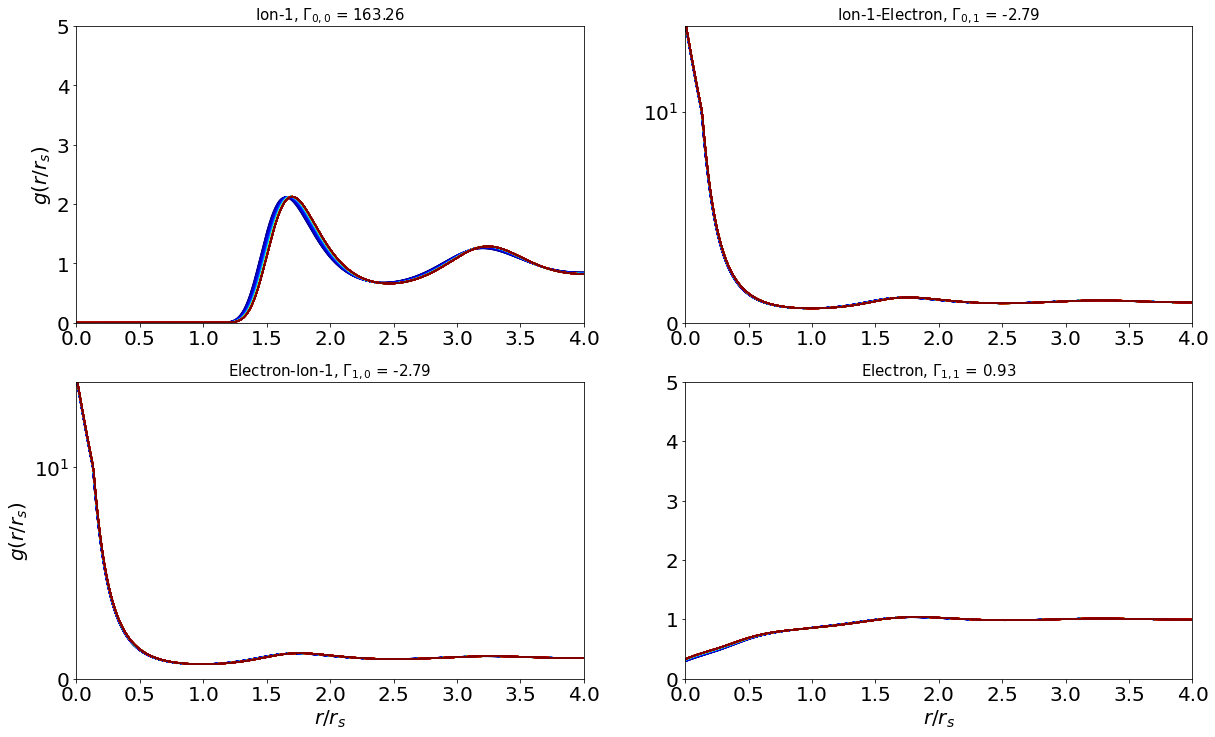

In [10]:
hnc2.plot_species_convergence(n_slices= int(len(hnc2.h_list)/10)  )

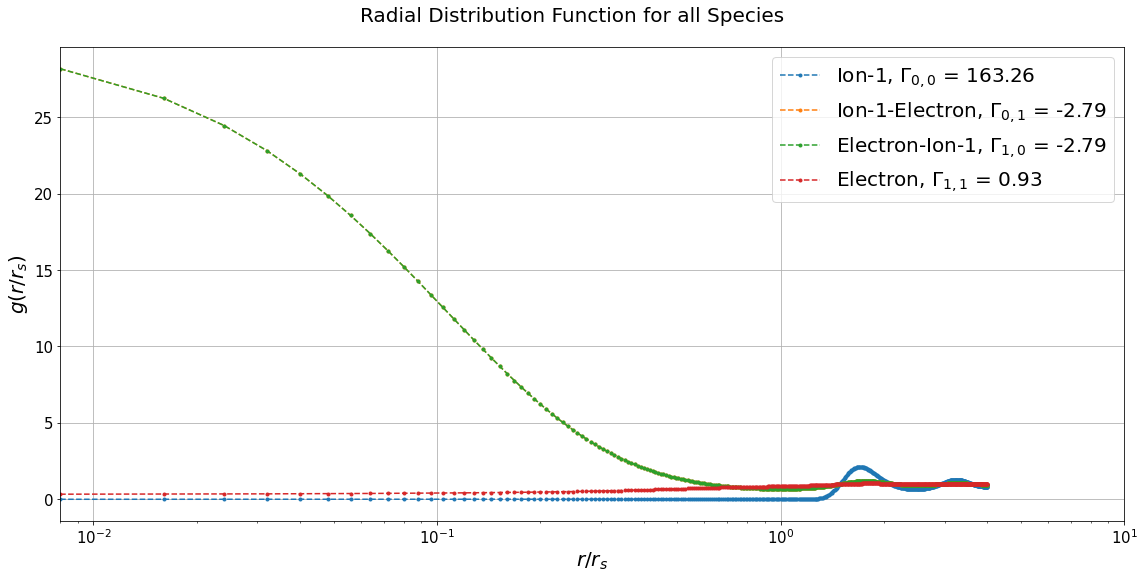

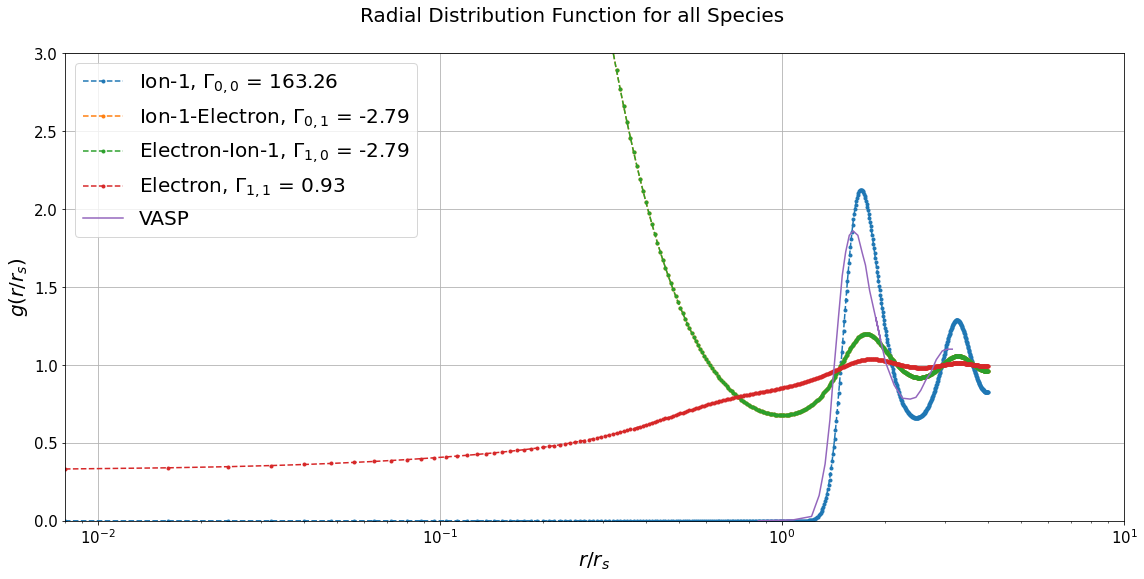

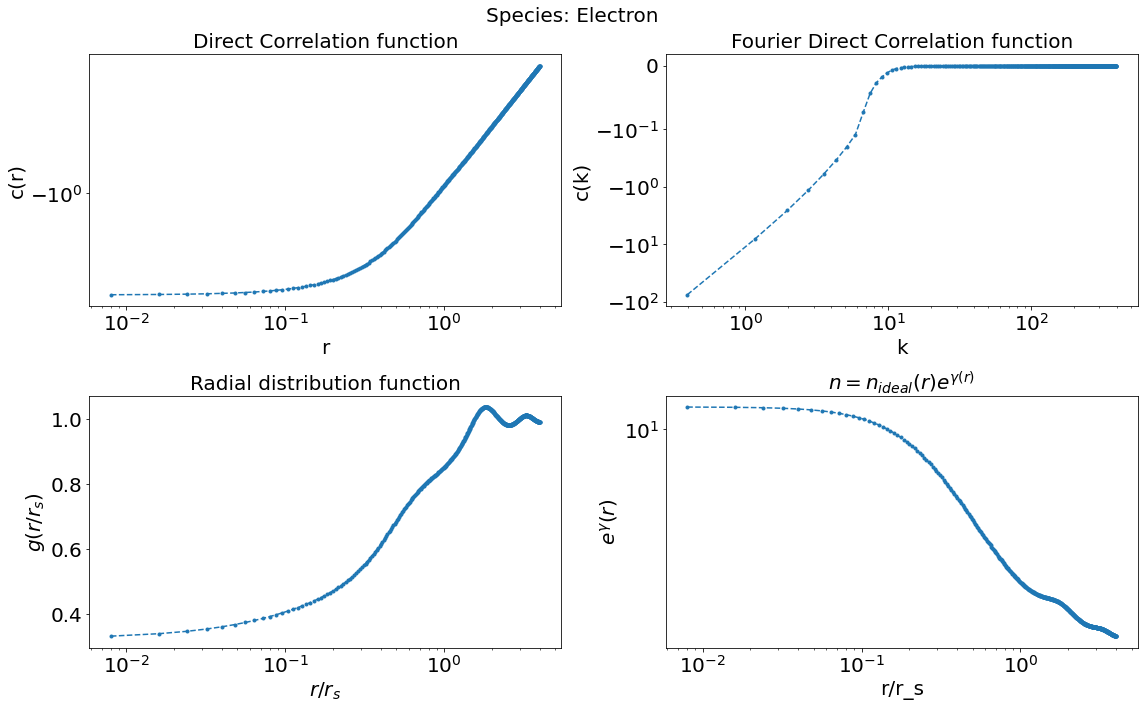

In [11]:
hnc2.plot_g_all_species()
# hnc2.plot_g_all_species(gmax=3,data_to_compare=['/home/zach/plasma/datasets/RDFs/Al_1.0eV_rs3_VASP.txt'], data_names=['VASP'])
hnc2.plot_g_all_species(gmax=3,data_to_compare=['/home/zach/plasma/datasets/RDFs/Al_0.5eV_rs3_KS-MD.txt'], data_names=['VASP'])
hnc2.plot_species((1,1))

In [ ]:
# np.savetxt("/home/zach/Downloads/Al_1.0eV_r3_QSPHNC.txt",np.array([hnc2.r_array,hnc2.h_r_matrix[0,0]+1]).T)

# Effective Potentials

In [ ]:
hnc2.invert_HNC(1)

In [ ]:
fig, ax = plt.subplots()

ax.plot(hnc2.r_array, 1+hnc2.heff_r_matrix[0,0],label= 'h')
ax.plot(hnc2.r_array, hnc2.ceff_r_matrix[0,0],label='c')
ax.plot(hnc2.r_array,np.log(1+hnc2.heff_r_matrix)[0,0],label='log(1+h)')
ax.set_yscale('symlog',linthresh=1e-5)
ax.set_xlim(1e-1,2)
# ax.set_xscale('log')
ax.legend()

In [ ]:
hnc2.βωeff_r_matrix

In [ ]:
from pandas import read_csv
from scipy.interpolate import interp1d
luke_file = '/home/zach/plasma/atomic_forces/data/Al_T1_tab.lammps.PAIR'

luke_data = read_csv(luke_file ,delim_whitespace=True,header=3, names=['r [A]','V [eV]','F [eV/A]'])
luke_r, luke_βV = 1e-10/aB/ri*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_r[165], luke_βV[165]
luke_βV_function = interp1d(luke_r, luke_βV,fill_value='extrapolate',bounds_error=False)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6),facecolor='w')
fig.suptitle(r"$T=${0:.1f} eV, $r_i$={1:.2f}".format(Te/eV,ri), fontsize=20)

ax.plot(luke_r, luke_βV,'k--', label="Luke Force Match")
ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0],'k-', label="Effective")
ax.plot(hnc2.r_array, hnc2.βu_r_matrix[0,0], label="Initial")
ax.plot(hnc2.r_array, βv_Yukawa(hnc2.r_array),label="Yukawa")
ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.set_ylim(-1,1e4)
ax.set_yscale('symlog',linthresh=1)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)

# Check!

In [ ]:
# N_species = 1
# Gamma = np.array(  [[1]])
# names = ["Ion Effective"] 
# kappa = 1
# rho = np.array([3/(4*np.pi)])
# hnc_check = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-3, kappa_multiscale=10,
#                        rho = rho, num_iterations=int(1e3), R_max=10, N_bins=1000, names=names)

# hnc_luke = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-3, kappa_multiscale=10,
#                        rho = rho, num_iterations=int(1e4), R_max=10, N_bins=1000, names=names)

# # check
# βu_r_matrix = np.nan_to_num( hnc2.βueff_r_matrix,nan = -np.log(1.e-16), posinf=-np.log(1e-16) ).copy()
# hnc_check.set_βu_matrix(βu_r_matrix)
# hnc_check.HNC_solve(alpha=1)

# # luke
# # βu_r_matrix[0,0]=luke_βV_function(hnc2.r_array)
# # hnc_luke.set_βu_matrix(βu_r_matrix)
# # hnc_luke.HNC_solve(alpha=1)


In [ ]:
# np.savetxt("example_veff_1eV_rs_3aBohr.txt", np.array([hnc_check.r_array, hnc_check.βu_r_matrix[0,0]]).T,header="r/r_s,   beta v_ii^eff   (both unitless)",delimiter=', ' )

In [ ]:
# hnc_check.plot_g_all_species()

In [ ]:
# fig, ax = plt.subplots(figsize=(10,6))

# ax.plot(hnc2.r_array, hnc2.h_r_matrix[0,0]+1,'.', label="Two Actual Species")
# ax.plot(hnc_check.r_array, hnc_check.h_r_matrix[0,0]+1,'-', label="One Effective Species")
# ax.plot(hnc_luke.r_array, hnc_luke.h_r_matrix[0,0]+1,'-', label="Luke HNC with Force Matched V")
# ax.set_ylabel(r'$g(r/r_s)$',fontsize=20)
# ax.set_xlabel(r'$r/r_s$',fontsize=20)
# ax.set_ylim(-0.1,3)
# ax.set_xlim(0,5)
# ax.tick_params(labelsize=15)
# ax.legend(fontsize=15)

# Curve Fitting

In [ ]:
from scipy.optimize import curve_fit

def yukawa_fit(r, Γ, κ,p):
    return  Γ/r*np.exp(-κ*r)

def yukawa_remaining_fit(r,a,b,c,d):
    return 1/(a+b*np.exp(c*(hnc2.r_array-d)))

def LJ_fit(r, a,b,m,n):
    return  1/(a*r**m + b/r**n) #+ v0

def yukawa_friedel_fit(r, Γ, κ1, a,κ2, k,  δ, v0):
    return  Γ/r*np.exp(-κ1*r) + a/r**3*np.exp(-κ2*r)*np.cos(k*r+δ) + v0

def yukawa_plus_fit(r, Γ, κ1, a,b,c):
    return  Γ/r*np.exp(-κ1*r)/(1+np.exp(b*(hnc2.r_array-c)))
# last_inf_index = int(np.argwhere(np.isinf(hnc2.βueff_r_matrix[0,0]))[-1] )

y_vals = curve_fit(yukawa_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0])
y_fit_data  = yukawa_fit(hnc2.r_array, y_vals[0][0],y_vals[0][1],y_vals[0][2])

y_remaining_vals = curve_fit(yukawa_remaining_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0]/y_fit_data)
y_remaining_fit_data  = yukawa_remaining_fit(hnc2.r_array, y_remaining_vals[0][0],y_remaining_vals[0][1],y_remaining_vals[0][2],y_remaining_vals[0][3])


# LJ_vals = curve_fit(LJ_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0],maxfev=int(1e5))
# yf_vals= curve_fit(yukawa_friedel_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0],maxfev=int(1e5))
# yp_vals= curve_fit(yukawa_plus_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0],maxfev=int(1e3))

In [ ]:
y_vals[0], y_remaining_vals[0]

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

g_data = hnc2.h_r_matrix[0,0] + 1

# LJ_fit_data  = LJ_fit(hnc2.r_array, LJ_vals[0][0],LJ_vals[0][1],LJ_vals[0][2],LJ_vals[0][3])
# yf_fit_data = yukawa_friedel_fit(hnc2.r_array, yf_vals[0][0],yf_vals[0][1],yf_vals[0][2],yf_vals[0][3],yf_vals[0][4],yf_vals[0][5],yf_vals[0][6])
# yp_fit_data = yukawa_plus_fit(hnc2.r_array, yp_vals[0][0],yp_vals[0][1],yp_vals[0][2],yp_vals[0][3],yp_vals[0][4])


ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0],'k-', label="Effective")
# ax.plot(hnc2.r_array, y_fit_data*y_remaining_fit_data,'--', label="Yukawa Fit")
ax.plot(hnc2.r_array, 81.87504124/hnc2.r_array*np.exp(-0.99115223*hnc2.r_array)/(0.92620556+0.7351028*np.exp(1.72217623*(hnc2.r_array-1.75197859))),'--', label="Fit")
# ax.plot(hnc2.r_array[1:], hnc2.βueff_r_matrix[0,0][1:]-hnc2.βueff_r_matrix[0,0][:-1],'k-', label="Effective")
# ax.plot(hnc2.r_array[1:], (y_fit_data*y_remaining_fit_data)[1:]-(y_fit_data*y_remaining_fit_data)[:-1],'--', label="Yukawa Fit")

# ax.plot(hnc2.r_array, LJ_fit_data,'--', label="Yukawa Fit")
# ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0]-y_fit_data*y_remaining_fit_data,'.', label="Yukawa Fit Ratio")
 
# ax.plot(hnc2.r_array,y_remaining_fit_data,'.', label="Yukawa Remaining Fit")

# ax.plot(hnc2.r_array, yf_fit_data,'.', label="Yukawa-Friedel Fit")
# ax.plot(hnc2.r_array, yp_fit_data,'.', label="Yukawa-Plus Fit")
# ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0]/yp_fit_data,'.', label="Yukawa-Plus Fit Ratio")
# ax.plot(hnc2.r_array, 1/(1+np.exp(3*(hnc2.r_array-2.5))),'.', label="Yukawa-Friedel Fit")

ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
# ax.set_ylim(-2,2)
ax.set_yscale('symlog',linthresh=1e-1)
ax.set_xlim(0,10)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)

In [ ]:
from scipy.interpolate import RBFInterpolator



RBFInterpolator(hnc2.r_array, hnc2.βueff_r_matrix[0,0]/y_fit_data)